# 3/8/21 - First fit to G544226.

## Experiment 1 : phase1_nlive = 200, phase1_tolerance = 0.5, phase2_nlive = 500, phase2_tolerance = 0.25, use effective radius from GAMA DR3 Sersic Photometry catalog (including errors) and upper limit (effective radius + error), normal mask, Source R_E (0->10*lens.inensity), 2 position, threshold=1.0

## Don't take the instance for the ellipticity and effective radius. Set same max effective radius.

In [1]:
### libraries
%matplotlib inline
# set workspace path
from pyprojroot import here
workspace_path = str(here())#'/data/sknabel/autolens_workspace'
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import matplotlib.pyplot as plt
from autoconf import conf
import autolens as al
import autolens.plot as aplt
import autofit as af
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.stats import sigma_clip as clip
from os import path
import time

# set datetime variable
datetime = time.strftime("%d%m%Y-%H%M%S")

# paths
autoz_path = '/data/sknabel/autoz_lens_model/'
file_path = f'{autoz_path}files/'
csv_path = f'{file_path}csv/'
fits_path = f'{file_path}fits/'
png_path = f'{autoz_path}visuals/png/'
pdf_path = f'{autoz_path}visuals/pdf/'

In /soft/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /soft/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /soft/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /soft/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /soft/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_tes

/data/sknabel/autoz_lens_model
Working Directory has been set to `/data/sknabel/autoz_lens_model`


Lens and source redshifts at [0.22704437] and [0.64982373].
Einstein radius prior: 0.8003723141149287
Plotting r-band


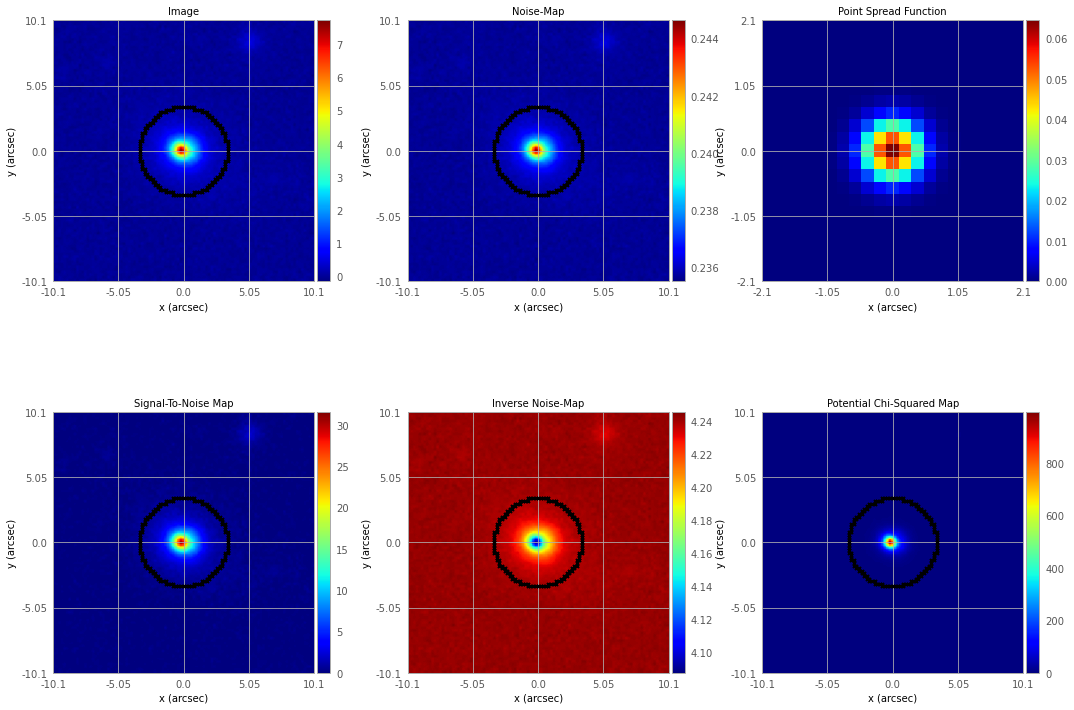

Plotting g-band


/soft/anaconda3/lib/python3.7/site-packages/autoarray/dataset/abstract_dataset.py:88: RuntimeWarning: divide by zero encountered in true_divide
  return 1.0 / self.noise_map


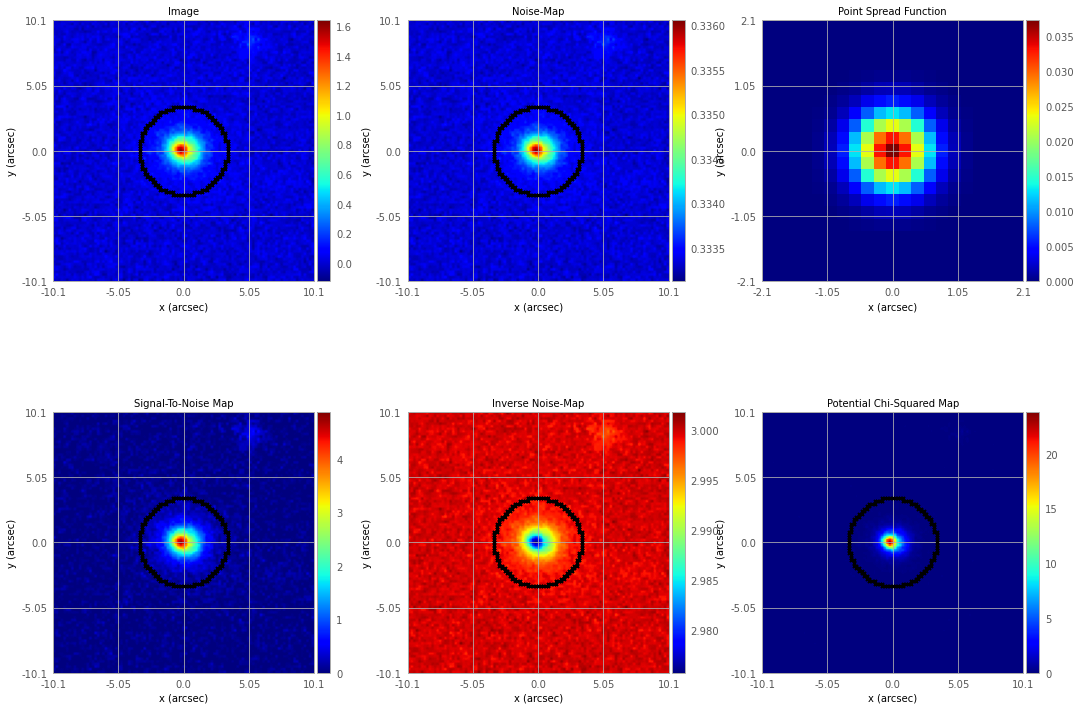

In [11]:
# this should be constant across experiments

gama_id = 544226
links_id = 3212

object_folder = f'{fits_path}G{gama_id}_{links_id}/'
output_folder = f'{autoz_path}output/G{gama_id}_{links_id}/'

# load object data table
links = pd.read_csv(f'{csv_path}/latest/links_sample_latest.csv')
lens_galaxy_data = links[links.GAMA_ID == gama_id]
zlens=lens_galaxy_data.zlens.values
zsource=lens_galaxy_data.zsource.values
einstein_radius=np.mean([lens_galaxy_data.theta_e_pm.values, lens_galaxy_data.theta_e_sis.values]) # take average of einstein radius estimates for prior
print(f'Lens and source redshifts at {zlens} and {zsource}.')
print(f'Einstein radius prior: {einstein_radius}')

# effective radius and error from DR3 sersic catalog
hdul = fits.open(f'{fits_path}SersicCatSDSS.fits')
hdul.verify('fix')
data = hdul[1].data
#print(data.columns)
#print(data.CATAID)
candidate = data[data.CATAID == gama_id]
re_r = candidate.GALRE_r
re_r_err = candidate.GALREERR_r
re_g = candidate.GALRE_g
re_g_err = candidate.GALREERR_u


# load r-band imaging
imaging_r = al.Imaging.from_fits(image_path=path.join(object_folder, f'{links_id}_r_image.fits'),
                              noise_map_path=path.join(object_folder, f'{links_id}_r_noisemap.fits'),
                              psf_path=path.join(object_folder, f'{links_id}_r_psf.fits'),
                               pixel_scales=0.2)

# load g-band imaging
imaging_g = al.Imaging.from_fits(image_path=path.join(object_folder, f'{links_id}_g_image.fits'),
                              noise_map_path=path.join(object_folder, f'{links_id}_g_noisemap.fits'),
                              psf_path=path.join(object_folder, f'{links_id}_g_psf.fits'),
                               pixel_scales=0.2)

# set up mask
mask = al.Mask2D.circular(
    shape_native=imaging_r.shape_native, pixel_scales=imaging_r.pixel_scales, sub_size=2, radius=3.5
)
visuals_2d = aplt.Visuals2D(mask=mask)

# plot subplots for first view
print('Plotting r-band')
imaging_plotter_r = aplt.ImagingPlotter( # this is where the noise is coming up weird
    imaging=imaging_r, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter_r.subplot_imaging()
print('Plotting g-band')
imaging_plotter_g = aplt.ImagingPlotter( # this is where the noise is coming up weird
    imaging=imaging_g, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter_g.subplot_imaging()

# set up grid and settings
settings_masked_imaging = al.SettingsMaskedImaging(grid_class=al.Grid2D)#, psf_shape_2d=imaging.psf.shape_2d)
settings = al.SettingsPhaseImaging(settings_masked_imaging=settings_masked_imaging)

#set up lens light profile
lens_start = al.GalaxyModel(
    redshift=zlens, bulge=al.lp.EllipticalSersic#, mass=al.mp.EllipticalIsothermal
)

# set priors
# lens position
lens_start.bulge.centre_0 = af.UniformPrior(lower_limit=-0.1, upper_limit=0.1)
lens_start.bulge.centre_1 = af.UniformPrior(lower_limit=-0.1, upper_limit=0.1)
# effective radius
#lens_start.bulge.effective_radius = af.UniformPrior(lower_limit=0.0, upper_limit=5.0) # why have I chosen 3 here? because the mask is 3...

In [20]:
print(re_g_err)

[85.12927]


In [12]:
# Start a pandas dataframe
performance_log = pd.DataFrame(columns=['Experiment', 
                                        'phase1_time', 
                                        'phase1_likelihood', 
                                        'phase2_time', 
                                        'phase2_likelihood' 
                                        ])

# load performance log from csv
#performance_log = pd.read_csv(f'{csv_path}G{gama_id}_{links_id}_performance_log.csv')
#print(performance_log)
#print(performance_log)

Plotting r-band


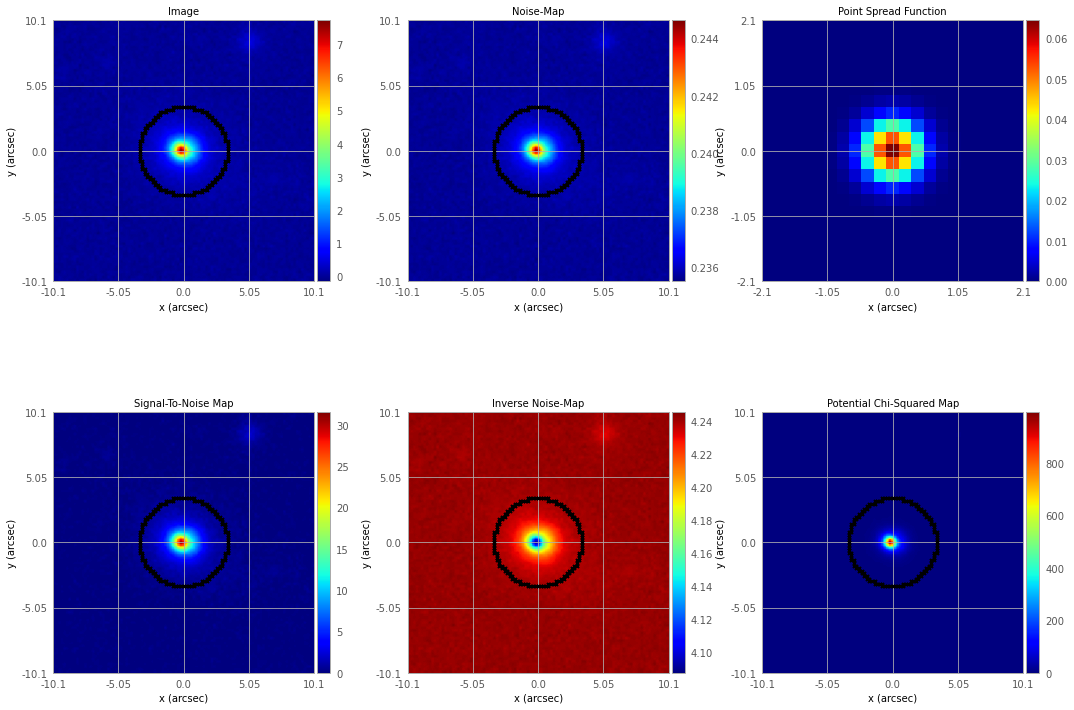

Galaxy (centre_0, UniformPrior, lower_limit = -0.2, upper_limit = 0.5), (centre_1, UniformPrior, lower_limit = -0.7, upper_limit = 0.0), (elliptical_comps_0, GaussianPrior, mean = 0.0, sigma = 0.3), (elliptical_comps_1, GaussianPrior, mean = 0.0, sigma = 0.3), (intensity, LogUniformPrior, lower_limit = 1e-06, upper_limit = 1000000.0), (effective_radius, GaussianPrior, mean = 1.2870473861694336, sigma = 0.0448497012257576), (sersic_index, UniformPrior, lower_limit = 0.5, upper_limit = 8.0)


In [22]:
# set experiment number
experiment_number = '1'

lens_start.bulge.effective_radius = af.GaussianPrior(mean=re_r, sigma=re_r_err, lower_limit=0.0, upper_limit=re_r+re_r_err)
lens_start.bulge.centre_0 = af.UniformPrior(lower_limit=-0.2, upper_limit=0.5)
lens_start.bulge.centre_1 = af.UniformPrior(lower_limit=-0.7, upper_limit=0.0)

# set up mask
#lens_mask = al.Mask2D.circular(
#    shape_native=imaging_r.shape_native, pixel_scales=imaging_r.pixel_scales, sub_size=2, radius=re_r #centre=(0.075, -0.075) 
#)
#visuals_2d = aplt.Visuals2D(mask=lens_mask)

# I can probably use the regular mask for this.

# plot subplots for first view
print('Plotting r-band')
imaging_plotter_r = aplt.ImagingPlotter(
    imaging=imaging_r, visuals_2d=visuals_2d
)
imaging_plotter_r.subplot_imaging()

# set up phase
phase1 = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix=f"{output_folder}", name=f"experiment_{experiment_number}_phase1_{datetime}", n_live_points=200,
        evidence_tolerance=0.5, walks = 10
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(lens=lens_start)#, source=source)
)

print(lens_start)

In [23]:
# run the phase
print('Phase running...')
tick = time.perf_counter()
phase1_result = phase1.run(dataset=imaging_r, mask=mask)
tock = time.perf_counter()
print(f'Work complete! Took us {tock-tick} seconds or {(tock-tick)/60} minutes.')

Phase running...


INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.
INFO:root:No Dynesty samples found, beginning new non-linear search. 
490it [00:13, 35.78it/s, +200 | bound: 0 | nc: 1 | ncall: 2707 | eff(%): 25.489 | loglstar:   -inf < -332.595 <    inf | logz: -341.035 +/-  0.372 | dlogz:  1.099 >  0.500]   
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
614it [00:13, 45.83it/s, +200 | bound: 0 | nc: 1 | ncall: 5251 | eff(%): 15.502 | loglstar:   -inf < -332.595 <    inf | logz: -341.654 +/-  0.381 | dlogz:  1.099 >  0.500]
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
617it [00:00, 5659.74it/s, bound: 0 | nc: 4 | ncall: 5271 | eff(%): 11.706 | loglstar:   -inf < -5193.278 <    inf | logz: -5202.347 +/-  0.362 | dlogz: 4919.348 >  0.500]/soft/anaconda3/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely

Work complete! Took us 447.2873549796641 seconds or 7.454789249661068 minutes.


Log likelihood: 416.0079396096031
Model: Galaxy (centre_0, GaussianPrior, mean = 0.030406098856058397, sigma = 0.05), (centre_1, GaussianPrior, mean = -0.11827448131190549, sigma = 0.05), (elliptical_comps_0, GaussianPrior, mean = -0.05114413191431855, sigma = 0.2), (elliptical_comps_1, GaussianPrior, mean = 0.08266476865210554, sigma = 0.2), (intensity, GaussianPrior, mean = 1.0404389009197414, sigma = 0.5202194504598707), (effective_radius, GaussianPrior, mean = 1.3492538687849653, sigma = 1.3492538687849653), (sersic_index, GaussianPrior, mean = 2.0436969632235398, sigma = 1.5), None, None


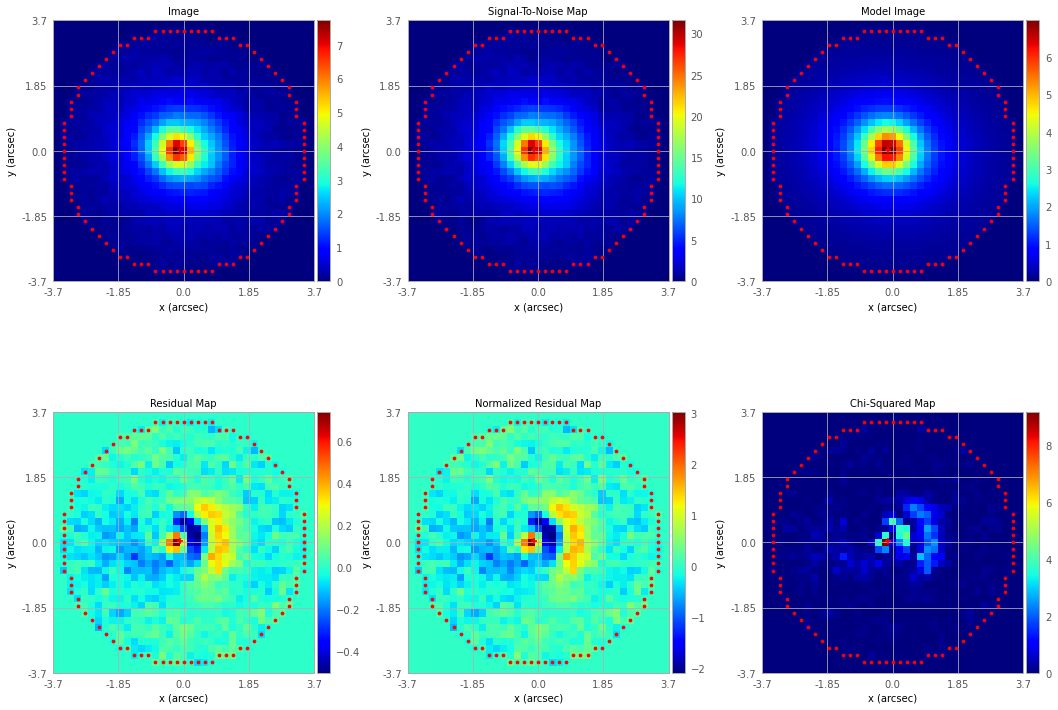

In [24]:
# write the results to the log
print(f'Log likelihood: {phase1_result.log_likelihood}')
print(f'Model: {phase1_result.model}')

phase1_time = tock-tick

# plot it!
fit_imaging_plotter = aplt.FitImagingPlotter(fit=phase1_result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()


In [25]:
# now phase 2!

#set up lens and source

# set stellar mass/light profile
bulge = af.PriorModel(al.lmp.EllipticalSersic)
bulge.take_attributes(source=phase1_result.model.galaxies.lens.bulge)

# set dark matter profile
dark = af.PriorModel(al.mp.SphericalNFWMCRLudlow)
dark.mass_at_200 = af.LogUniformPrior(lower_limit=1e8, upper_limit=1e15)
dark.redshift_object = zlens
dark.redshift_source = zsource

lens = al.GalaxyModel(
    redshift=zlens, bulge=bulge, dark=dark
)

source = al.GalaxyModel(
    redshift=zsource, bulge=al.lp.SphericalExponential)

# make lens intensity default to 0.1 +- 0.1 because red to green makes it wonky
#lens.bulge.intensity = af.GaussianPrior(mean=0.1, sigma=0.1)

# set uniform m_l ratio
#lens.bulge.mass_to_light_ratio = af.UniformPrior(lower_limit=0.0, upper_limit=100000.0) # leave it default

# make dark matter centered at stellar mass center
lens.bulge.centre = phase1_result.instance.galaxies.lens.bulge.centre
lens.dark.centre = lens.bulge.centre

# make lens effective radius for g-band
lens.bulge.effective_radius = af.GaussianPrior(mean=re_g, sigma=re_g_err, lower_limit=0.0, upper_limit=re_g+re_g_err)

# einstein radius
#lens.mass.einstein_radius = af.GaussianPrior(mean=einstein_radius, sigma=0.3*einstein_radius) # take sigma to be 30% of mean # hmmm

# source position
source.bulge.centre_0 = af.UniformPrior(lower_limit=-3, upper_limit=3)
source.bulge.centre_1 = af.UniformPrior(lower_limit=-3, upper_limit=3)
source.bulge.effective_radius = af.UniformPrior(lower_limit=0.0, upper_limit=5.0)
#source.bulge.intensity = af.UniformPrior(lower_limit=0.0, upper_limit=10*lens.bulge.intensity)

print(f'Lens: {lens}')
print(f'Source: {source}')

Lens: Galaxy (elliptical_comps_0, GaussianPrior, mean = -0.05114413191431855, sigma = 0.2), (elliptical_comps_1, GaussianPrior, mean = 0.08266476865210554, sigma = 0.2), (intensity, GaussianPrior, mean = 1.0404389009197414, sigma = 0.5202194504598707), (effective_radius, GaussianPrior, mean = 1.4225456714630127, sigma = 85.1292724609375), (sersic_index, GaussianPrior, mean = 2.0436969632235398, sigma = 1.5), (mass_to_light_ratio, LogUniformPrior, lower_limit = 1e-06, upper_limit = 1000000.0), (mass_at_200, LogUniformPrior, lower_limit = 100000000.0, upper_limit = 1000000000000000.0)
Source: Galaxy (centre_0, UniformPrior, lower_limit = -3.0, upper_limit = 3.0), (centre_1, UniformPrior, lower_limit = -3.0, upper_limit = 3.0), (intensity, LogUniformPrior, lower_limit = 1e-06, upper_limit = 1000000.0), (effective_radius, UniformPrior, lower_limit = 0.0, upper_limit = 5.0)


Plotting g-band


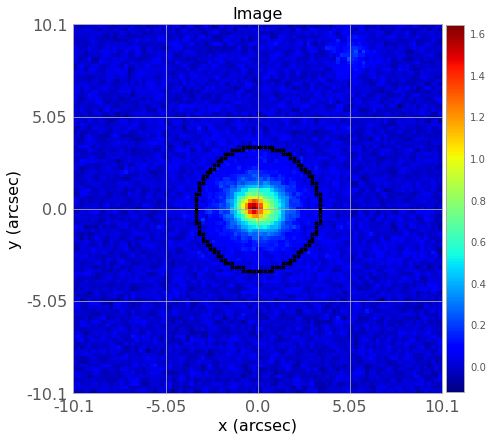

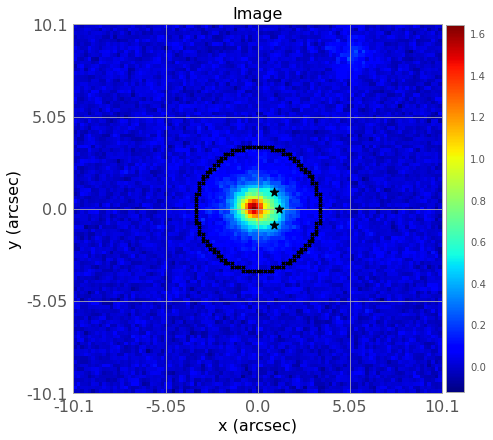

In [29]:
# Set up the positions... (GUI is not working...)

# plot the r-band image to see it
print('Plotting g-band')
imaging_plotter_g = aplt.ImagingPlotter( # this is where the noise is coming up weird
    imaging=imaging_g, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter_g.figures(image=True)

# set positions
imaging_g.positions = al.Grid2DIrregular(
    [(0.9, 0.9), (0.0, 1.2), (-0.9, 0.9)]#, (-0.8, 1.0), (-1.0, 0.5), (0.3, 1.1)]
)

# plot the image
visuals_2d = aplt.Visuals2D(mask=mask, positions=imaging_g.positions)
imaging_plotter_g = aplt.ImagingPlotter(imaging=imaging_g, visuals_2d=visuals_2d)
imaging_plotter_g.figures(image=True)

In [30]:
# set the settings to include the positions
settings_lens = al.SettingsLens(positions_threshold=1.0)

settings = al.SettingsPhaseImaging(
    settings_masked_imaging=settings_masked_imaging, settings_lens=settings_lens
)

In [31]:
# set up phase
phase2 = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix=f'{output_folder}', name=f"experiment_{experiment_number}_phase2_fit_{datetime}", n_live_points=500,
        evidence_tolerance=0.25, walks=10, facc=0.4
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(lens=lens, source=source)#, source=source)
)

In [ ]:
# run phase
# run the phase
print('Phase running...')
tick = time.perf_counter()
phase2_result = phase2.run(dataset=imaging_g, mask=mask)
tock = time.perf_counter()
print(f'Work complete! Took us {tock-tick} seconds or {(tock-tick)/60} minutes.')

INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.


Phase running...


INFO:root:No Dynesty samples found, beginning new non-linear search. 
190it [01:18,  2.42it/s, +500 | bound: 3 | nc: 1 | ncall: 3002 | eff(%): 22.985 | loglstar:   -inf < 48.959 <    inf | logz: 41.669 +/-  0.610 | dlogz:  1.099 >  0.250]
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
422it [01:37,  4.34it/s, +500 | bound: 6 | nc: 1 | ncall: 5503 | eff(%): 16.754 | loglstar:   -inf < 101.099 <    inf | logz: 93.346 +/-  0.495 | dlogz:  1.099 >  0.250]
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
644it [01:37,  6.62it/s, +500 | bound: 11 | nc: 1 | ncall: 8005 | eff(%): 14.291 | loglstar:   -inf < 101.099 <    inf | logz: 92.964 +/-    nan | dlogz:  1.058 >  0.250]       
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).
880it [01:41,  8.70it/s, +500 | bound: 14 | nc: 1 | ncall: 10515 | eff(%): 13.124 | loglstar:   -inf < 112.772 <    inf | logz: 104.104 +/-  0.797 | 

In [43]:
# write the results to the log
print(f'Log likelihood: {phase2_result.log_likelihood}')
print(f'Model: {phase2_result.model}')

phase2_time=tock-tick

log = open(f"{output_folder}experiment_log", 'a') # append the log
lines = [f'Experiment {experiment_number} \n',
         f'r-band \n',
         f'Time to convergence: {phase1_time} seconds \n', 
         f'Log likelihood: {phase1_result.log_likelihood} \n',
         f'Model: {str(phase1_result.model)} \n',
         f'g-band \n',
         f'Time to convergence: {phase2_time} seconds \n', 
         f'Log likelihood: {phase2_result.log_likelihood} \n', 
         f'Model: {str(phase2_result.model)} \n', '\n'] # set lines to write the model result
log.writelines(lines) # write lines
log.close()

Log likelihood: 163.12567460341367
Model: Galaxy (elliptical_comps_0, GaussianPrior, mean = -0.12091435428141925, sigma = 0.3834496602337272), (elliptical_comps_1, GaussianPrior, mean = 0.2343720367847074, sigma = 0.40316819858068653), (intensity, GaussianPrior, mean = 0.05327837349927905, sigma = 0.053457071609182116), (effective_radius, GaussianPrior, mean = 1.8721355646722821, sigma = 1.8721355646722821), (sersic_index, GaussianPrior, mean = 2.579741735636044, sigma = 3.288079141762924), (mass_to_light_ratio, GaussianPrior, mean = 181.8572165584121, sigma = 876600.6750142531), (mass_at_200, GaussianPrior, mean = 648246628092.3497, sigma = 855339469584063.2), Galaxy (centre_0, GaussianPrior, mean = 0.17950319923088398, sigma = 3.1452481122322196), (centre_1, GaussianPrior, mean = -0.2460993764355576, sigma = 3.200838299782494), (intensity, GaussianPrior, mean = 0.0032364826225853866, sigma = 497809.84392553405), (effective_radius, GaussianPrior, mean = 2.6099664545813908, sigma = 2.6

  Experiment  phase1_time  phase1_likelihood  phase2_time  phase2_likelihood
0          1   403.158289         445.398771  1164.151751         163.125675


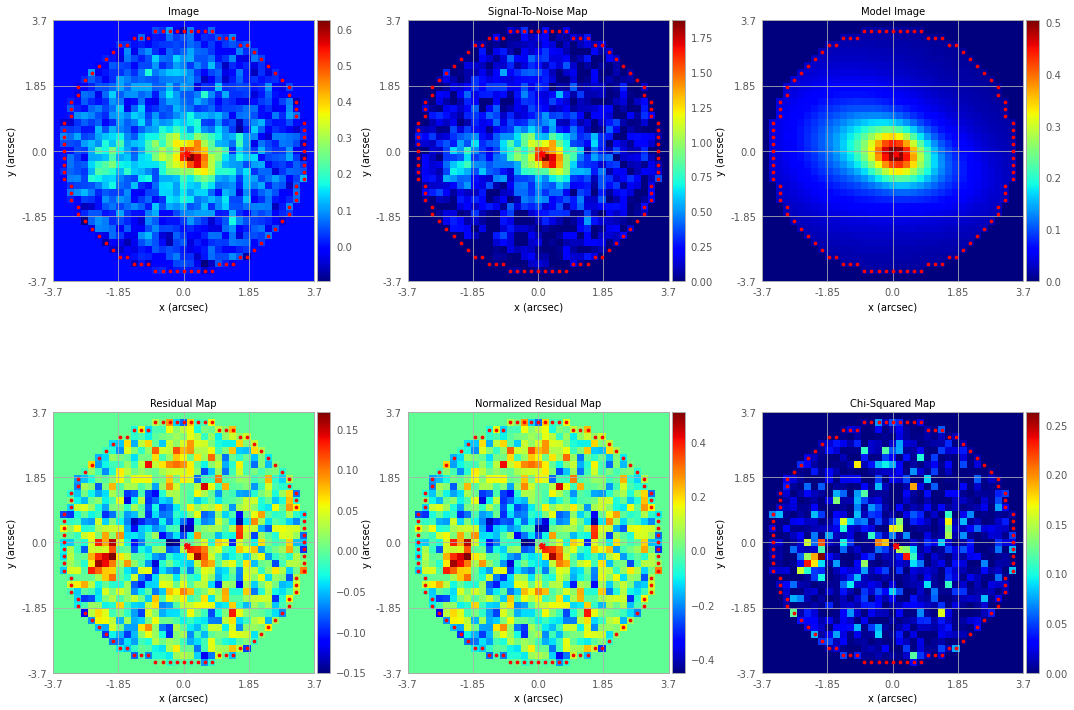

In [44]:
# append performance log
data_list = [[experiment_number, 
            phase1_time,
            phase1_result.log_likelihood,
            phase2_time, 
            phase2_result.log_likelihood,
             ]]
new_dataframe_entry = pd.DataFrame(data_list,
                                  columns=['Experiment', 
                                           'phase1_time', 
                                           'phase1_likelihood', 
                                           'phase2_time', 
                                           'phase2_likelihood', 
                                           ])
performance_log = pd.concat([performance_log, new_dataframe_entry])
print(performance_log)
performance_log.to_csv(f'{csv_path}G{gama_id}_{links_id}_performance_log.csv')
#print(phase_result.model)
# get samples to see how it ran?
#log_likelihoods = phase_result.samples.log_likelihoods
#x = np.arange(0, len(log_likelihoods), 1)
#plt.plot(x[500:], log_likelihoods[500:])
#plt.xlim()

# plot it!
fit_imaging_plotter = aplt.FitImagingPlotter(fit=phase2_result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

In [ ]:
aplt.show()